# Setup

In [1]:
import os, sys 
import math, itertools as it, numpy as np, h5py
import matplotlib as mpl ; import matplotlib.pyplot as plt ; plt.ion() 
import dataview as dv ; from dataview import style_group_default as stg_list
from lhpd.val_err import val_err
plt.rcParams['legend.fontsize']='x-small'

#execfile('config_c23pt_boost1_xx_xy.py') # plot_ff, calc_ff FIXME mv to lib functions
execfile('config_lcdb.py')
execfile('pproc_largeq2.py')
execfile('ens_setup.py')
execfile('fit_c2.py')

In [2]:
# TODO replace with 'from nucleon_ff_exp.formfac import *

#plot exp
#execfile('formfac_exp_kelly.py')
import formfac_exp_kelly as ff_kelly ; reload(ff_kelly)
import formfac_exp_alberico as ff_albe ; reload(ff_albe)
import formfac_exp_data as ff_data; reload(ff_data)

from formfac_exp_kelly import mu_p, mu_n
def get_curve_ff(q2r, ff, param, q2pow=0) :
    m = None
    if   'albe' == param : m = ff_albe
    elif 'kelly' == param : m = ff_kelly
    else : raise ValueError, param
        
    if   'F1u'==ff: y = q2r**q2pow * (2*m.F1p(q2r)+m.F1n(q2r))
    elif 'F1d'==ff: y = q2r**q2pow * (2*m.F1n(q2r)+m.F1p(q2r))
    elif 'F2u'==ff: y = q2r**q2pow * (2*m.F2p(q2r)+m.F2n(q2r))
    elif 'F2d'==ff: y = q2r**q2pow * (2*m.F2n(q2r)+m.F2p(q2r))
        
    elif 'F1p'==ff: y = q2r**q2pow * m.F1p(q2r)
    elif 'F1n'==ff: y = q2r**q2pow * m.F1n(q2r)
    elif 'F2p'==ff: y = q2r**q2pow * m.F2p(q2r)
    elif 'F2n'==ff: y = q2r**q2pow * m.F2n(q2r)

    elif 'F2d1p'==ff: y = q2r**q2pow * (m.F2p(q2r)/m.F1p(q2r))
    elif 'F2d1n'==ff: y = q2r**q2pow * (m.F2n(q2r)/m.F1n(q2r))
    elif 'GEdMp'== ff: y = q2r**q2pow * m.GEp(q2r)/m.GMp(q2r)
    elif 'GEdMn'== ff: y = q2r**q2pow * m.GEn(q2r)/m.GMn(q2r)
    else: raise ValueError, ff
        
    return y

def plot_curve_ff(q2r, ff, param, q2pow=0, yfactor=1., ax=None, stg=stg_list[0], label=None):
    if None is ax : ax = dv.make_std_axes()
    y = get_curve_ff(q2r, ff, param, q2pow=q2pow)
    ax.plot(q2r, yfactor*y, label=label, **stg.line())
    return ax
def calc_muGEdM(q2, F2d1):
    tau = q2 / 4. / ff_albe.mp**2
    return (1. - tau * F2d1) / (1. + F2d1)
def calc_F2d1(q2, GEdM):
    tau = q2 / 4. / ff_albe.mp**2
    return (1. - GEdM) / (tau + GEdM)
# comparing ffs: ratio #1/#2
def plot_ff_cmp_1d2(h5fname1, h5fname2, flav, op, i_ff, tsep,
                     rsplan=('jk',1), 
                     ax=None, label=None, stg=stg_list[0]) :
    if None is ax : ax = dv.make_std_axes()
    ffd = []
    xrd = []
    for h5fn in [ h5fname1, h5fname2 ] :
        h5f = h5py.File(h5fn, 'r')
        h5d = h5f['/proton/%s/%s/ratio_pltx_avg/dt%d' % (op, flav, tsep)]
        ffd.append(h5d[:,0,:,i_ff])
        xrd.append(h5d.attrs['q2_list'])
        h5f.close()
    y_a, y_e = lhpd.calc_avg_err(ffd[0] / ffd[1], rsplan)
    q2r = xrd[0]
    ax.errorbar(q2r*ainv**2, y_a, yerr=y_e, label=label, **stg.edotline())
    ax.axhline(y=0, c='k', ls='-')
    ax.axhline(y=1, c='k', ls=':')
    ax.axhline(y=-1, c='k', ls=':')
    return ax


In [3]:
mlat    = 0.465
latsize = np.r_[32,32,32,64]
t_axis  = 3
latsize_x   = latsize[:3]
ainv    = 2.099
ama     = 'ub'
had     = 'proton'
rsplan  = ('jk',1)
ZV      = 1./1.205
Q2max   = 14 # for plots

op      = 'tensor1'
#c3pt_improv = '0imp'  # only improvement term
c3pt_improv = '1imp'  # only improvement term


tsep_list = [6,7,8,9,10]
#set_select = 'PX4_bxp20'
set_select = 'PQ3_bqp15'
if 'PX4_bxp20' == set_select :
    # ======= PX4 ==========
    #data_tag= '20180426.n736'
    data_tag= '20180515.PX4.n1346'
    ssgrp = [ srcsnkpair(dt, 'GN2x50bxp20',[2,0,0], 'GN2x50bxm20',[-2,0,0]) 
              for dt in tsep_list ]
    smtag = 'GN2x50bxp20_GN2x50bxm20'
    mc_list=[ mc_case([k,0,0],[-4,0,0], 'posSzplus') 
              for k in np.r_[-1:5] ]
    mcgrp_list=[ [mc] for mc in mc_list]

elif   'PQ3_bqp15' == set_select :
    # ======= PQ3 ==========
    #data_tag= '20180503.PQ3.n796'
    data_tag= '20180509.PQ3.n1346'
    ssgrp = [ srcsnkpair(dt, 'GN2x50bqp15',[1.5,1.5,0], 'GN2x50bqm15',[-1.5,-1.5,0])
              for dt in tsep_list ]
    smtag = 'GN2x50bqp15_GN2x50bqm15'
    mc_list=[ mc_case([k,k,0],[-3,-3,0], 'posSzplus') 
              for k in np.r_[-1:4] ]
    mcgrp_list=[ [mc] for mc in mc_list]
else : raise ValueError, set_select

print ssgrp    
print mc_list

data_dir= 'data/%s' % data_tag
#out_dir="ff-q2dep.%s.%s_%s_%s.dt%d--%d.tskip%d_%s" % (
#    ama,sm_tag,ksrc_tag,ksnk_tag, tmin,tmax, tskip, c3pt_improv)
out_dir = 'data_out.ff/%s' % data_tag
try :    os.mkdir(out_dir)
except : pass 

#c2fit_h5fname="c2fit.%s.%s_%s_%s.h5" % (
#    ama,sm_tag,ksrc_tag,ksrc_tag)
fig_dir = 'fig_out.ff/%s' % data_tag
try :    os.mkdir(fig_dir)
except : pass 


# for tests
flav    = 'U+D' 
tsep    = 8      
gg      = ens_data_get(ama=ama, had=had, flav=flav, op=op, data_top=data_dir, 
                latsize=latsize, mlat=mlat)
tmin,tmax,tskip=6,10,3

c2fit_h5fname = '%s/c2fit.v2.proton.h5' % out_dir
print c2fit_h5fname
ff_h5fname="%s/ff.%s.%s.dt%d--%d.tskip%d_%s.h5" % (out_dir, ama, smtag, tmin, tmax, tskip, c3pt_improv)
print ff_h5fname

[<GN2x50bqm15|GN2x50bqp15>(T=6), <GN2x50bqm15|GN2x50bqp15>(T=7), <GN2x50bqm15|GN2x50bqp15>(T=8), <GN2x50bqm15|GN2x50bqp15>(T=9), <GN2x50bqm15|GN2x50bqp15>(T=10)]
[posSzplus<[-3, -3, 0]|[-1, -1, 0]>, posSzplus<[-3, -3, 0]|[0, 0, 0]>, posSzplus<[-3, -3, 0]|[1, 1, 0]>, posSzplus<[-3, -3, 0]|[2, 2, 0]>, posSzplus<[-3, -3, 0]|[3, 3, 0]>]
data_out.ff/20180509.PQ3.n1346/c2fit.v2.proton.h5
data_out.ff/20180509.PQ3.n1346/ff.ub.GN2x50bqp15_GN2x50bqm15.dt6--10.tskip3_1imp.h5


In [4]:
# test read: import from test_read.py [2017/10/06]
# reg.operator
mc1 = mc_list[-1]
x=gg.get_threept_conn_flav_(flav, smtag, tsep, op, 'H4_T1_d4r1', mc1.get_p3src(),mc1.get_p3snk(), 'posSzplus')
a,e=lhpd.calc_avg_err(x[:,1].real) ; print a, a/e 
a,e=lhpd.calc_avg_err(x[:,3].real) ; print a, a/e
    
# improvement term
x=gg.get_threept_1imp_flav_(flav, smtag, tsep, op, 'H4_T1_d4r1', mc1.get_p3src(),mc1.get_p3snk(), 'posSzplus', 'conn')
a,e=lhpd.calc_avg_err(x[:,1].real) ; print a, a/e
a,e=lhpd.calc_avg_err(x[:,3].real) ; print a, a/e


[ -4.97403985e-14  -6.07601482e-14  -7.58012311e-14  -8.74288951e-14
  -7.80106005e-14  -7.49009640e-14  -7.49089680e-14  -6.81513044e-14
  -6.53027944e-14] [ -6.66334459 -10.27267367 -14.45517929 -19.44760132 -17.54668895
 -12.90019965 -12.63453196 -12.7523301   -9.39826491]
[  1.65861513e-14   5.31178981e-14   4.52825459e-14   4.89787595e-14
   4.50835546e-14   4.50897975e-14   4.33400195e-14   4.34839367e-14
   6.94444855e-15] [ 1.61429784  5.81210886  7.32068029  7.75432913  9.1021275   9.56108152
  8.58285452  7.05362133  0.88574229]
[  1.53920312e-15  -1.05716785e-15  -6.51509038e-15   1.39489533e-14
   1.09711491e-14   2.96694686e-15   2.31845411e-15   5.40032060e-15
   1.19969920e-14] [ 0.17741454 -0.19226404 -1.16333428  1.83126374  1.62938615  0.52009301
  0.38134655  0.77190285  1.24180894]
[ -2.55081979e-13  -2.30253692e-13  -2.51968770e-13  -2.60453123e-13
  -2.71530462e-13  -2.79369009e-13  -2.59631074e-13  -2.39590375e-13
  -2.43610416e-13] [-21.11512414 -23.01569076 -29

## Fitting c2pt

In [5]:
# fit params
execfile('fit_c2.py')
c2fit_kw      = dict(rsplan=('jk',1), c2fit_nexp=2, method='nlm', opt_kw=dict(disp=0))
c2fit_mc_list = mc_list
#XXX moved to header XXX c2fit_h5fname = '%s/c2fit.v2.proton.h5' % out_dir ; 
print c2fit_h5fname
c2fit_h5f     = h5py.File(c2fit_h5fname)
tr_list = [np.r_[2:15],
           np.r_[3:15], 
           np.r_[4:15]
]

data_out.ff/20180509.PQ3.n1346/c2fit.v2.proton.h5


In [6]:
# do fit
for tr in tr_list :
    runme_fit_save_c2pt(c2fit_h5f.require_group('/c2fit'), gg, tr, c2fit_mc_list, 
                        ssgrp[0], **c2fit_kw)
c2fit_h5f.flush()

***  posSzplus<[-4, 0, 0]|[-1, 0, 0]> <GN2x50bxm20|GN2x50bxp20>(T=6) (2, 14)
c2_scale=6.818334e-12
c2r_ncov[13,13] evals = 1.109030e-01 .. 5.791414e+00
  popt =  [  1.61850904e-11   5.51487314e-01   3.04998924e-11   9.74020004e-01]
  chi2/dof = 2.998416 / 11 = 0.272583
c2pt_c0        	1.618(105)e-11                 	1.
c2pt_e0        	5.515(104)e-1                  	0.955678	1.
c2pt_c1        	3.05(87)e-11                   	0.740430	0.633384	1.
c2pt_de1_0     	9.74(205)e-1                   	0.865055	0.764403	0.970542	1.

***  posSzplus<[-4, 0, 0]|[0, 0, 0]> <GN2x50bxm20|GN2x50bxp20>(T=6) (2, 14)
c2_scale=6.335040e-11
c2r_ncov[13,13] evals = 6.012891e-02 .. 7.316382e+00
  popt =  [  1.24948250e-10   4.90155036e-01   1.65256586e-10   6.64124071e-01]
  chi2/dof = 11.080721 / 11 = 1.007338
c2pt_c0        	1.2495(315)e-10                	1.
c2pt_e0        	4.902(33)e-1                   	0.953291	1.
c2pt_c1        	1.653(60)e-10                  	0.532037	0.410697	1.
c2pt_de1_0     	6.64(

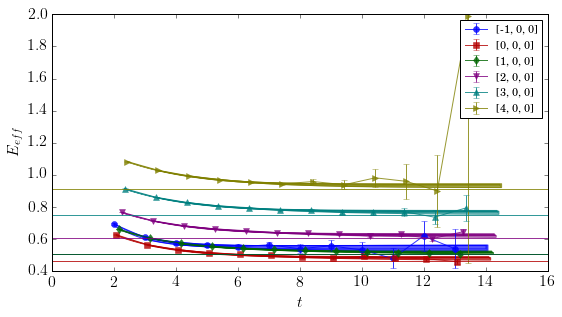

In [7]:
# plot Eeff fits
fig_eeff, ax_eeff=plt.subplots(ncols=1,nrows=1, figsize=(8,4.5))
fig_eeff.tight_layout(h_pad=0, w_pad=1, rect=[0.02,0.02,1.,1.])

c2fit_p3src_list = [mc.get_p3src() for mc in c2fit_mc_list]
ax_eeff=runme_plot_fit_c2pt(c2fit_h5f['/c2fit'], tr_list, c2fit_p3src_list, 
                        xlim=[0,16], ylim=[0.4,2.0], xl=r'$t$', yl=r'$E_{eff}$',
                        model=('nexp',2), ax=ax_eeff, **c2fit_kw)
for i_p3src, p3src in enumerate(c2fit_p3src_list) :
    ax_eeff.axhline(y=lhpd.latcorr.lorentz_energy(mlat, latsize_x, p3src), 
                    **stg_list[i_p3src].line())
    
ax_eeff.legend(numpoints=1, fontsize='x-small')
#ax_eeff.set_ylim([0.4,1.2])
ax_eeff.figure.savefig('%s/Eeff_fit.pdf' % fig_dir)

# Calc&plot FF

In [6]:
execfile('plot_ff.py')

flav_list1=['U', 'D', 'U-D', 'U+D', 'P', 'N']
tsep_list=np.r_[tmin:tmax+1]
method_list1 = [('ratio_pltx',), ('ratio_pltx_avg',), ('ratio_summ',), ('fit_c3',)]

#XXX moved to header XXX ff_h5fname="%s/ff.%s.%s.dt%d--%d.tskip%d_%s.h5" % (out_dir, ama, smtag, tmin, tmax, tskip, c3pt_improv)
print ff_h5fname

data_out.ff/20180509.PQ3.n1346/ff.ub.GN2x50bqp15_GN2x50bqm15.dt6--10.tskip3_1imp.h5


In [7]:
# calc form factors
ff_param_kw=dict(mlat=mlat, latsize=latsize, rsplan=rsplan, ama='ub', 
                 had='proton', data_top=data_dir, tskip=tskip, c2fit_nexp=2,
                c3pt_improv=c3pt_improv)
runme_calc_save_ff(ff_h5fname, mcgrp_list, ssgrp, 
                   flav_list1, [ op ], method_list1, 
                   c2fit_dgrp=h5py.File(c2fit_h5fname, 'r')['/c2fit/tr3--14'], 
                   **ff_param_kw)

# i_eqn=0 done, chi2/dof=7.5(50)e-28/11=6.8(45)e-29
# i_eqn=1 done, chi2/dof=2.5(16)e-28/11=2.3(15)e-29
# i_eqn=2 done, chi2/dof=9.2(60)e-28/11=8.3(54)e-29
(1346, 3)
(1346,)
fit_c3 : me_fit chi2=5(10)e-27/1=5(10)e-27
# i_eqn=0 done, chi2/dof=3.3(19)e-28/11=3.0(17)e-29
# i_eqn=1 done, chi2/dof=1.9(12)e-28/11=1.7(11)e-29
# i_eqn=2 done, chi2/dof=1.08(70)e-27/11=9.8(63)e-29
(1346, 3)
(1346,)
fit_c3 : me_fit chi2=9(18)e-28/1=9(18)e-28
# i_eqn=0 done, chi2/dof=1.4(12)e-28/11=1.3(11)e-29
# i_eqn=1 done, chi2/dof=4.6(34)e-29/11=4.2(31)e-30
# i_eqn=2 done, chi2/dof=6.6(49)e-28/11=6.0(45)e-29
(1346, 3)
(1346,)
fit_c3 : me_fit chi2=4.7(69)e-28/1=4.7(69)e-28
# i_eqn=0 done, chi2/dof=9.3(65)e-29/11=8.5(59)e-30
# i_eqn=1 done, chi2/dof=4.7(32)e-30/11=4.3(29)e-31
# i_eqn=2 done, chi2/dof=3.4(23)e-28/11=3.1(21)e-29
(1346, 3)
(1346,)
fit_c3 : me_fit chi2=2.8(14)e-28/1=2.8(14)e-28
# i_eqn=0 done, chi2/dof=1.32(82)e-28/11=1.20(74)e-29
# i_eqn=1 done, chi2/dof=4.4(32)e-28/11=4.0(29)e-29
(1346, 2)
(1346,)

In [9]:
#plot form factors
plt.rcParams['legend.fontsize']='x-small'
plt.rcParams['legend.loc']='best'

if 'tensor1' == op :
    if '1imp' == c3pt_improv : plot_list = ['F1','F2']
    else : plot_list = ['F1','F2','Q4F1','Q4F2','Q2F2dF1','GE2GM']
elif 'pstensor1' == op :
    plot_list = ['GA', 'GP']
elif 'tensor2s2' == op :
    plot_list = ['A20', 'B20', 'C20']
elif 'tensor2s2' == op :
    plot_list = ['A20t', 'B20t', 'C20']
else:raise ValueError, op
    
runme_plot_all_ff(ff_h5fname, flav_list1, 
                  plot_list, tsep_list, 
                  ['ratio_pltx_avg', 'fit_c3'],
                  out_dir=fig_dir, mlat=mlat, ainv=ainv, xr=[0,10])

U F1
# data_out.ff/ff-q2dep.U.F1
xlabel='$Q^2$ [GeV${}^2$]'  ylabel='$F_1^{U}$'
U F2
# data_out.ff/ff-q2dep.U.F2
xlabel='$Q^2$ [GeV${}^2$]'  ylabel='$F_2^{U}$'
U Q4F1
# data_out.ff/ff-q2dep.U.Q4F1
U Q4F2
# data_out.ff/ff-q2dep.U.Q4F2
U Q2F2dF1
# data_out.ff/ff-q2dep.U.Q2F2dF1
q2_slice = slice(None, None, None)
U GE2GM
# data_out.ff/ff-q2dep.U.GE2GM
q2_slice = slice(None, None, None)
D F1
# data_out.ff/ff-q2dep.D.F1
xlabel='$Q^2$ [GeV${}^2$]'  ylabel='$F_1^{D}$'
D F2
# data_out.ff/ff-q2dep.D.F2
xlabel='$Q^2$ [GeV${}^2$]'  ylabel='$F_2^{D}$'
D Q4F1
# data_out.ff/ff-q2dep.D.Q4F1
D Q4F2
# data_out.ff/ff-q2dep.D.Q4F2
D Q2F2dF1
# data_out.ff/ff-q2dep.D.Q2F2dF1
q2_slice = slice(None, None, None)
D GE2GM
# data_out.ff/ff-q2dep.D.GE2GM
q2_slice = slice(None, None, None)
U-D F1
# data_out.ff/ff-q2dep.U-D.F1
xlabel='$Q^2$ [GeV${}^2$]'  ylabel='$F_1^{U-D}$'
U-D F2
# data_out.ff/ff-q2dep.U-D.F2
xlabel='$Q^2$ [GeV${}^2$]'  ylabel='$F_2^{U-D}$'
U-D Q4F1
# data_out.ff/ff-q2dep.U-D.Q4F1
U-D Q4F2
# data

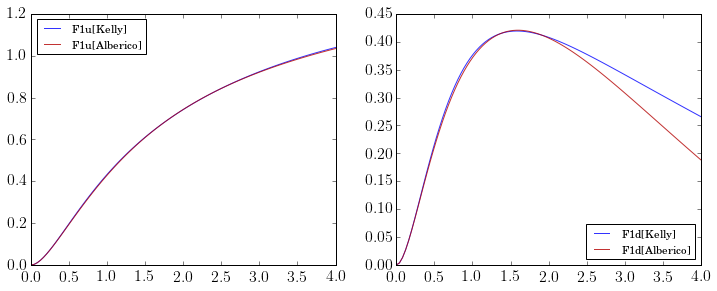

In [11]:
# Q4*F1u, Q4*F1d, Q4*F2u, Q4*F2d
fig_F1ud, ax_F1ud=plt.subplots(figsize=(12,4.5), ncols=2, nrows=1)
Q2r=np.r_[0:4:100j]
# F1d
plot_curve_ff(Q2r, 'F1u', 'kelly', q2pow=2,
              ax=ax_F1ud[0],stg=stg_list[0],label=r'F1u[Kelly]')
plot_curve_ff(Q2r, 'F1u', 'albe',  q2pow=2,
              ax=ax_F1ud[0],stg=stg_list[1],label=r'F1u[Alberico]')
ax_F1ud[0].legend(loc='best')
# F1d
plot_curve_ff(Q2r, 'F1d', 'kelly', q2pow=2,yfactor=2.5, 
              ax=ax_F1ud[1],stg=stg_list[0],label=r'F1d[Kelly]')
plot_curve_ff(Q2r, 'F1d', 'albe',  q2pow=2,yfactor=2.5, 
              ax=ax_F1ud[1],stg=stg_list[1],label=r'F1d[Alberico]')
ax_F1ud[1].legend(loc='best')

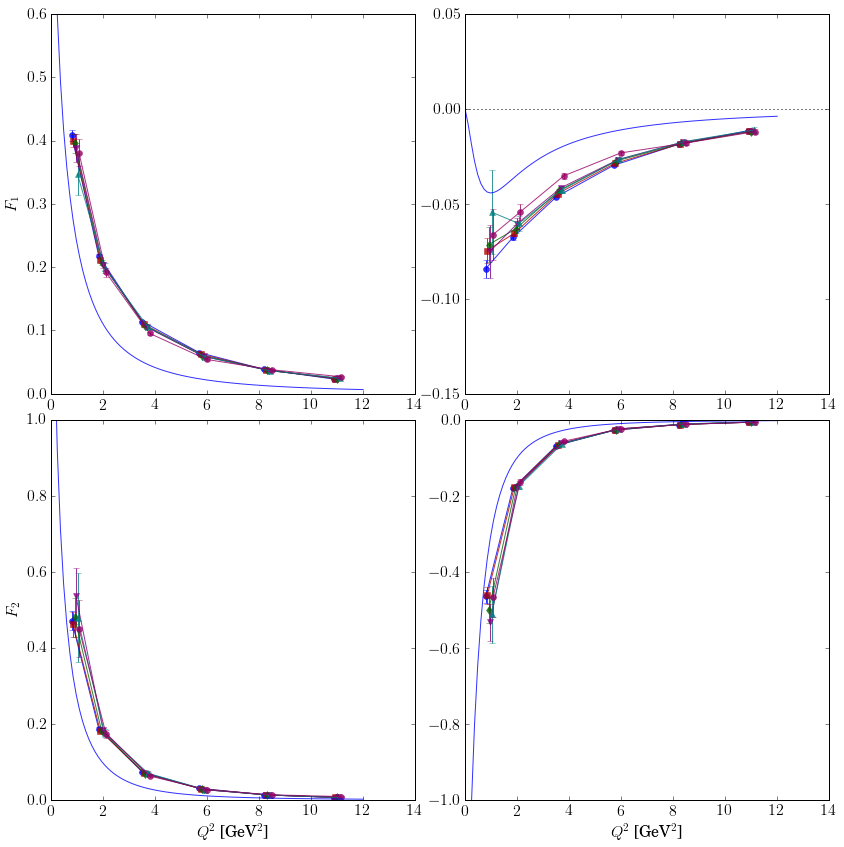

In [10]:
# F1p, F1n, F2p, F2n
fig_F12ud, ax_F12ud=plt.subplots(figsize=(2*6, 2*6), ncols=2, nrows=2)
fig_F12ud.tight_layout(h_pad=0, w_pad=1, rect=[0.02,0.02,1.,1.])
ff_h5f_r = h5py.File(ff_h5fname, 'r')
Q2r=np.r_[0:12:100j]
# F1p
plot_q2dep_cmp_ff(ff_h5f_r["/proton/tensor1/P"], 'F1', tsep_list, ['ratio_pltx_avg', 'fit_c3'], 
                     yfactor=ZV, mlat=mlat, ainv=ainv, xr=[0,Q2max], yr=[0,0.6],
                     ax=ax_F12ud[0,0], stg_fit_c3=dv.style_group_default[10])
plot_curve_ff(Q2r, 'F1p', 'albe', q2pow=0,yfactor=1, 
              ax=ax_F12ud[0,0],stg=stg_list[0],label=r'[Alberico]')

# F1n
plot_q2dep_cmp_ff(ff_h5f_r["/proton/tensor1/N"], 'F1', tsep_list, ['ratio_pltx_avg', 'fit_c3'], 
                     yfactor=ZV, mlat=mlat, ainv=ainv, xr=[0,Q2max], yr=[-.15,0.05],
                     ax=ax_F12ud[0,1], stg_fit_c3=dv.style_group_default[10])
plot_curve_ff(Q2r, 'F1n', 'albe', q2pow=0,yfactor=1, 
              ax=ax_F12ud[0,1],stg=stg_list[0],label=r'[Alberico]')

# F2p
plot_q2dep_cmp_ff(ff_h5f_r["/proton/tensor1/P"], 'F2', tsep_list, ['ratio_pltx_avg', 'fit_c3'], 
                     yfactor=ZV, mlat=mlat, ainv=ainv, xr=[0,Q2max], yr=[0,1],
                     ax=ax_F12ud[1,0], stg_fit_c3=dv.style_group_default[10])
plot_curve_ff(Q2r, 'F2p', 'albe', q2pow=0,yfactor=1, 
              ax=ax_F12ud[1,0],stg=stg_list[0],label=r'[Alberico]')

# F2n
plot_q2dep_cmp_ff(ff_h5f_r["/proton/tensor1/N"], 'F2', tsep_list, ['ratio_pltx_avg', 'fit_c3'], 
                     yfactor=ZV, mlat=mlat, ainv=ainv, xr=[0,Q2max], yr=[-1,0],
                     ax=ax_F12ud[1,1], stg_fit_c3=dv.style_group_default[10])
plot_curve_ff(Q2r, 'F2n', 'albe', q2pow=0,yfactor=1, 
              ax=ax_F12ud[1,1],stg=stg_list[0],label=r'[Alberico]')


ax_F12ud[0,0].set_ylabel(r'$F_1$') ; ax_F12ud[0,0].set_xlabel('')
ax_F12ud[0,1].set_ylabel('') ; ax_F12ud[0,1].set_xlabel('')
ax_F12ud[1,0].set_ylabel(r'$F_2$') 
ax_F12ud[1,1].set_ylabel('')
    
ax_F12ud[0,0].figure.savefig('%s/ff-q2dep.PN.F12.pdf' % (fig_dir,))

q2_slice = slice(None, None, None)
q2_slice = slice(None, None, None)


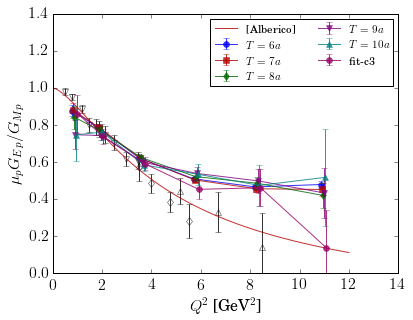

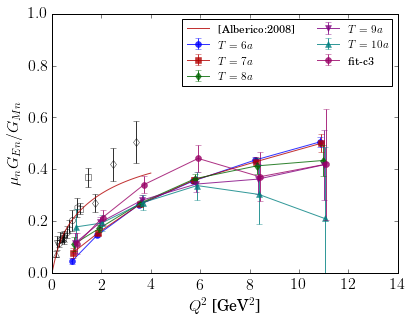

In [11]:
# compare ratios to exp data, fits
ax_muGEdMp = plt.figure(figsize=(6,4.5)).add_axes([.16, .16, .8, .8])
ax_muGEdMn = plt.figure(figsize=(6,4.5)).add_axes([.16, .16, .8, .8])
ff_h5f_r = h5py.File(ff_h5fname, 'r')
mu_p_lat = mu_p/1.12  # use extrap. lat.values of GM/GE(Q2->0) instead of phys!
mu_n_lat = mu_n

# mu_p GEp/GMp
Q2r=np.r_[0:12:100j]
ax_muGEdMp.axhline(y=0, ls=':', c='k')

for i,v in enumerate(ff_data.muGEdMp) :
    d = v['data']
    if v['include'] :
        ax_muGEdMp.errorbar(d[:,0], d[:,2], yerr=d[:,3], 
                          #label=v['citekey'], 
                          **v['stg'].cp(mfc='none').edot())
#plot_curve_ff(Q2r, 'GEdMp', 'kelly', q2pow=0,yfactor=mu_p, 
#              ax=ax_muGEdMpn[0],stg=stg_list[0],label=r'$\mu_p G_{Ep}/G_{Mp}$ [Kelly]')
plot_curve_ff(Q2r, 'GEdMp', 'albe',  q2pow=0,yfactor=mu_p, 
              ax=ax_muGEdMp, stg=stg_list[1], label=r'[Alberico]')
plot_q2dep_cmp_GE2GM(ff_h5f_r["/proton/tensor1/P"], tsep_list, ['ratio_pltx_avg', 'fit_c3'], 
                     yfactor=mu_p_lat, mlat=mlat, ainv=ainv,
                     xr=[0,Q2max], yr=[0,1.4],
                     ax=ax_muGEdMp, stg_fit_c3=dv.style_group_default[10])
ax_muGEdMp.legend(loc='best', ncol=2, numpoints=1)
ax_muGEdMp.set_ylabel(r'$\mu_p G_{Ep}/G_{Mp}$')
                      
# mu_n GEn/GMn
Q2r = np.r_[0:4:100j]
ax_muGEdMn.axhline(y=0, ls=':', c='k')
for i,v in enumerate(ff_data.GEn) :
    d = v['data']
    ysc = mu_n / ff_albe.GMn(d[:,0])
    if v['include'] :
        ax_muGEdMn.errorbar(d[:,0], ysc * d[:,2], yerr=ysc * d[:,3], 
                          #label=v['citekey'], 
                          **v['stg'].cp(mfc='none').edot())
        
#plot_curve_ff(Q2r, 'GEdMn', 'kelly', q2pow=0,yfactor=mu_n, 
#              ax=ax_muGEdMn,stg=stg_list[0],label=r'$\mu_n G_{En}/G_{Mn}$ [Kelly]')
plot_curve_ff(Q2r, 'GEdMn', 'albe',  q2pow=0,yfactor=mu_n, 
              ax=ax_muGEdMn,stg=stg_list[1],label=r'[Alberico:2008]')

plot_q2dep_cmp_GE2GM(ff_h5f_r["/proton/tensor1/N"], tsep_list, ['ratio_pltx_avg', 'fit_c3'], 
                     yfactor=mu_n_lat, mlat=mlat, ainv=ainv,
                     xr=[0,Q2max], yr=[0,1.],
                     ax=ax_muGEdMn, stg_fit_c3=dv.style_group_default[10])
ax_muGEdMn.legend(loc='best',ncol=2, numpoints=1)
ax_muGEdMn.set_ylabel(r'$\mu_n G_{En}/G_{Mn}$')

ax_muGEdMp.figure.savefig('%s/ff-q2dep.P.muGEdM.pdf' % (fig_dir,))
ax_muGEdMn.figure.savefig('%s/ff-q2dep.N.muGEdM.pdf' % (fig_dir,))

q2_slice = slice(None, None, None)


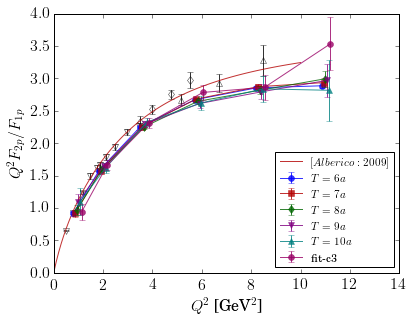

In [12]:
# compare ratios to exp data, fits
ax_Q2F2d1p = plt.figure(figsize=(6,4.5)).add_axes([.16, .16, .8, .8])
ff_h5f_r = h5py.File(ff_h5fname, 'r')

# Q2 F2p/F1p
Q2r=np.r_[0:10:100j]
ax_Q2F2d1p.axhline(y=0, ls=':', c='k')
for i,v in enumerate(ff_data.muGEdMp) :
    if v['include'] :
        d = v['data']
        z_a, z_e = [], []
        for x, y, dy in it.izip(d[:,0], d[:,2], d[:,3]):
            z = x * calc_F2d1(x, val_err(y,dy)/mu_p)
            z_a.append(z.v) ; z_e.append(z.e)
        ax_Q2F2d1p.errorbar(d[:,0], z_a, yerr=z_e,
                          #label=v['citekey'], 
                          **v['stg'].cp(mfc='none').edot())
plot_curve_ff(Q2r, 'F2d1p', 'albe',  q2pow=1, 
              ax=ax_Q2F2d1p, stg=stg_list[1], label=r'$[Alberico:2009]')
plot_q2dep_cmp_F2dF1(ff_h5f_r["/proton/tensor1/P"], tsep_list, ['ratio_pltx_avg', 'fit_c3'], 
                     mlat=mlat, q2pow=1, ainv=ainv,
                     ax=ax_Q2F2d1p, stg_fit_c3=dv.style_group_default[10])
ax_Q2F2d1p.set_xlim([0,Q2max])
ax_Q2F2d1p.set_ylim([0,4.])

ax_Q2F2d1p.legend(loc='best', numpoints=1)
ax_Q2F2d1p.set_ylabel(r'$Q^2 F_{2p}/F_{1p}$')

ax_Q2F2d1p.figure.savefig('%s/ff-q2dep.P.Q2F2d1.pdf' % (fig_dir,))

Axes(0.16,0.16;0.8x0.8) Axes(0.16,0.16;0.8x0.8)


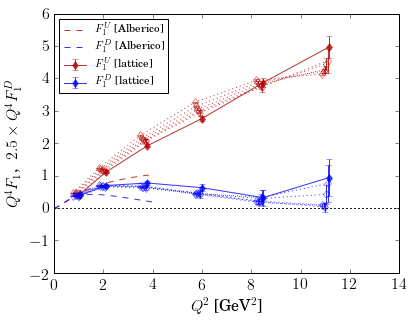

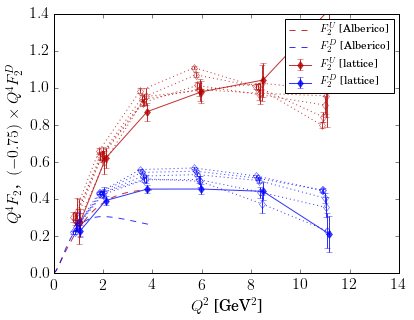

In [13]:
ax_Q4F1ud = plt.figure(figsize=(6,4.5)).add_axes([.16, .16, .8, .8])
ax_Q4F2ud = plt.figure(figsize=(6,4.5)).add_axes([.16, .16, .8, .8])
print ax_Q4F1ud, ax_Q4F2ud
ff_h5f_r = h5py.File(ff_h5fname, 'r')
stg_U, stg_D = stg_list[1], stg_list[0]

# Q4F1ud
Q2r=np.r_[0:4:100j]
ax_Q4F1ud.axhline(y=0, ls=':', c='k')
#for i,v in enumerate(ff_data.muGEdMp) :
#    d = v['data']
#    if v['include'] :
#        ax_muGEdMp.errorbar(d[:,0], d[:,2], yerr=d[:,3], 
#                          #label=v['citekey'], 
#                          **v['stg'].cp(mfc='none').edot())
plot_curve_ff(Q2r, 'F1u', 'albe',  q2pow=2,
              ax=ax_Q4F1ud, stg=stg_U.cp(ls='--'),label=r'$F_1^U$ [Alberico]')
plot_q2dep_cmp_ff(ff_h5f_r["/proton/tensor1/U"], 'F1', tsep_list, ['ratio_pltx_avg', 'fit_c3'], 
                  yfactor=ZV, mlat=mlat, ainv=ainv, q2pow=2, 
                  xr=[0,Q2max], yr=[-2,6],
                  ax=ax_Q4F1ud, label=r'$F_1^U$ [lattice]',
                  stg_list=[stg_U.cp(marker='d', mfc='none', ls=':')]*5, 
                  stg_fit_c3=stg_U.cp(marker='d'))

plot_curve_ff(Q2r, 'F1d', 'albe',  q2pow=2, yfactor=2.5,
              ax=ax_Q4F1ud, stg=stg_D.cp(ls='--'),label=r'$F_1^D$ [Alberico]')
plot_q2dep_cmp_ff(ff_h5f_r["/proton/tensor1/D"], 'F1', tsep_list, ['ratio_pltx_avg', 'fit_c3'], 
                  yfactor=2.5*ZV, mlat=mlat, ainv=ainv, q2pow=2,
                  xr=[0,Q2max], yr=[-2,6],
                  ax=ax_Q4F1ud, label=r'$F_1^D$ [lattice]',
                  stg_list=[stg_D.cp(marker='d', mfc='none', ls=':')]*5, 
                  stg_fit_c3=stg_D.cp(marker='d'))

#ax_Q4F1ud.set_xlim([0,12])
ax_Q4F1ud.legend(loc='best', numpoints=1)
ax_Q4F1ud.set_ylabel(r'$Q^4 F_1$, $\;2.5\times Q^4 F_1^D$')
                      
Q2r=np.r_[0:4:100j]
ax_Q4F2ud.axhline(y=0, ls=':', c='k')
#for i,v in enumerate(ff_data.muGEdMp) :
#    d = v['data']
#    if v['include'] :
#        ax_muGEdMp.errorbar(d[:,0], d[:,2], yerr=d[:,3], 
#                          #label=v['citekey'], 
#                          **v['stg'].cp(mfc='none').edot())
plot_curve_ff(Q2r, 'F2u', 'albe',  q2pow=2,
              ax=ax_Q4F2ud, stg=stg_U.cp(ls='--'), label=r'$F_2^U$ [Alberico]')
plot_q2dep_cmp_ff(ff_h5f_r["/proton/tensor1/U"], 'F2', tsep_list, ['ratio_pltx_avg', 'fit_c3'], 
                  yfactor=ZV, mlat=mlat, ainv=ainv, q2pow=2,
                  xr=[0,Q2max], yr=[0,1.4],
                  ax=ax_Q4F2ud, label=r'$F_2^U$ [lattice]',
                  stg_list=[stg_U.cp(marker='d', mfc='none', ls=':')]*5, 
                  stg_fit_c3=stg_U.cp(marker='d'))

plot_curve_ff(Q2r, 'F2d', 'albe',  q2pow=2, yfactor=-.75,
              ax=ax_Q4F2ud, stg=stg_D.cp(ls='--'),label=r'$F_2^D$ [Alberico]')
plot_q2dep_cmp_ff(ff_h5f_r["/proton/tensor1/D"], 'F2', tsep_list, ['ratio_pltx_avg', 'fit_c3'], 
                  yfactor=-.75*ZV, mlat=mlat, ainv=ainv, q2pow=2,
                  xr=[0,Q2max], yr=[0,1.4],
                  ax=ax_Q4F2ud, label=r'$F_2^D$ [lattice]',
                  stg_list=[stg_D.cp(marker='d', mfc='none', ls=':')]*5, 
                  stg_fit_c3=stg_D.cp(marker='d'))

#ax_Q4F2ud.set_xlim([0,12])
#ax_Q4F2ud.set_ylim([0,1.4])

ax_Q4F2ud.legend(loc='best', numpoints=1)
ax_Q4F2ud.set_ylabel(r'$Q^4 F_2$, $\;(-0.75)\times Q^4 F_2^D$')

ax_Q4F1ud.figure.savefig('%s/ff-q2dep.UD.Q4F1.pdf' % (fig_dir,))
ax_Q4F2ud.figure.savefig('%s/ff-q2dep.UD.Q4F2.pdf' % (fig_dir,))

# comparison O(a^1)/O(a^0)

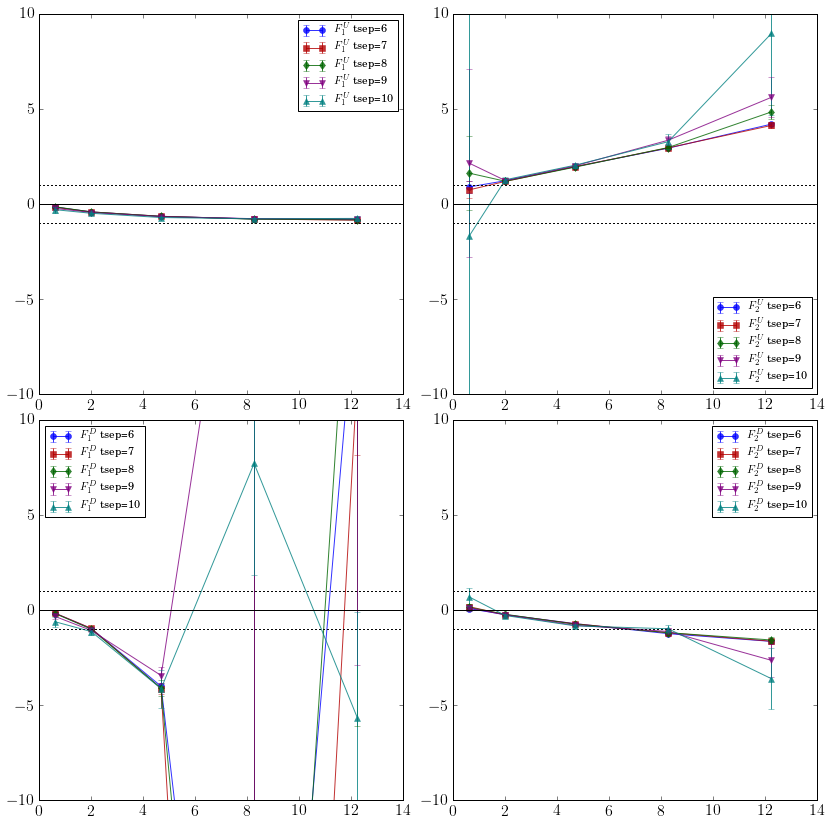

In [8]:
fig_cmp1d2, ax_cmp1d2 = plt.subplots(nrows=2, ncols=2, figsize=(2*6,2*6))
fig_cmp1d2.tight_layout(h_pad=0, w_pad=1, rect=[0.02,0.02,1.,1.])

def gff_name_latex(op, i_ff, flav):
    xname = {'tensor1'   : ['F_1', 'F_2'],
             'pstensor1' : ['G_A', 'G_P'],
            }
    return r'$%s^%s$' % (xname[op][i_ff], flav)

for (op, flav, i_ff), ax in it.izip(
        it.product(['tensor1'], ['U', 'D'], [0,1]),
        ax_cmp1d2.flat) :
    for (i_tsep, tsep) in enumerate(tsep_list) :
        plot_ff_cmp_1d2(
            "%s/ff.%s.%s.dt%d--%d.tskip%d_%s.h5" % (out_dir, ama, smtag, tmin, tmax, tskip, '1imp'),
            "%s/ff.%s.%s.dt%d--%d.tskip%d_%s.h5" % (out_dir, ama, smtag, tmin, tmax, tskip, '0imp'),
#            '%s/ff.ub.GN2x50bxp20_GN2x50bxm20.dt6--10.tskip3_1imp.h5' % out_dir,
#            '%s/ff.ub.GN2x50bxp20_GN2x50bxm20.dt6--10.tskip3_0imp.h5' % out_dir,
            flav, op, i_ff, tsep, 
            ax=ax, label='%s tsep=%d'% (gff_name_latex(op, i_ff, flav), tsep), 
            stg=stg_list[i_tsep])
        ax.set_xlim([0,14])
        ax.set_ylim([-10,10])
    ax.legend(loc='best')
fig_cmp1d2.savefig('%s/ff-q2dep.UD.F12.O1dO2.pdf' %(fig_dir,))

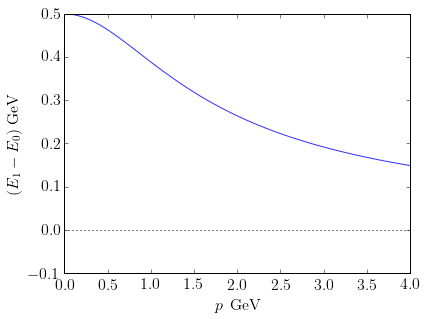

In [36]:
ax_dE = plt.figure(figsize=(6,4.5)).add_axes([.16, .16, .8, .8])
p_r=np.r_[0:4:100j]
m1,m2=1.,1.5
e1_r = np.sqrt(m1**2 + p_r**2)
e2_r = np.sqrt(m2**2 + p_r**2)
ax_dE.plot(p_r, e2_r - e1_r, **stg_list[0].line())
ax_dE.set_xlabel(r'$p\,\;\mathrm{GeV}$')
ax_dE.set_ylabel(r'$(E_1-E_0)\;\mathrm{GeV}$')
ax_dE.axhline(y=0, ls=':', c='k')